In [1]:
import os
import numpy as np
import cv2
from glob import glob
import itertools
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.initializers import glorot_uniform

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
#parameters
classes = 4
IMAGE_SIZE = [224,224]
H, W = 224, 224
channel = 3
num_class = 3
batch_size = 64
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

## Data Pipeline

In [3]:
def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*", "*.jpg")))
    

    return images 

In [4]:
def process_image(path):
    #decode the path
    path = path.decode()
    #read image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #resize the image
    image = cv2.resize(image, [224, 224])
    #scale the image
    image = image / 255.0
    #change the data type of image
    image = image.astype(np.float32)

    #labeling the image
    class_name = path.split("/")[-2]
    class_idx = class_names.index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return image, class_idx

In [5]:
def parse(path):
    image, labels = tf.numpy_function(process_image, [path], (tf.float32, tf.int32))
    labels = tf.one_hot(labels, 4)
    image.set_shape([224, 224, 3])
    labels.set_shape(4)
  
    return image, labels

In [6]:
#tensorflow dataset
def tf_dataset(images, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images))
    dataset = dataset.map(parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(8)
    return dataset

In [7]:
#callbacks parameter //paths
model_path = "vgg16_for_brain_tumor.h5"
csv_path = "brain_tumor_1.csv"

## Model

In [8]:
model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [9]:
#freeze training existing layer
for layer in model.layers:
  layer.trainable = False

In [10]:
#build our layers
x = layers.Flatten()(model.output)

In [11]:
#set last layer
prediction_layer = layers.Dense(4, activation='softmax' )(x)
#declare the model
model = Model(inputs=model.input, outputs=prediction_layer)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-7, verbose=1)
]

In [14]:
#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
#dataset path
train_path = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"

In [16]:
x_train = load_data(train_path)
x_test = load_data(test_path)
print(f"Train:{len(x_train)} - Test:{len(x_test)}")

Train:5712 - Test:1311


In [17]:
#tensor dataset
train_df = tf_dataset(x_train)
test_df = tf_dataset(x_test)

In [18]:
model.fit(
    train_df,
    validation_data=test_df,
    epochs=15,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/15
90/90 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.8396
Epoch 1: val_loss improved from inf to 0.30596, saving model to vgg16_for_brain_tumor.h5
90/90 [==============================] - 80s 716ms/step - loss: 0.4354 - accuracy: 0.8396 - val_loss: 0.3060 - val_accuracy: 0.8932 - lr: 0.0010
Epoch 2/15
90/90 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9294
Epoch 2: val_loss improved from 0.30596 to 0.21150, saving model to vgg16_for_brain_tumor.h5
90/90 [==============================] - 32s 357ms/step - loss: 0.1975 - accuracy: 0.9294 - val_loss: 0.2115 - val_accuracy: 0.9275 - lr: 0.0010
Epoch 3/15
90/90 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.9527
Epoch 3: val_loss improved from 0.21150 to 0.18368, saving model to vgg16_for_brain_tumor.h5
90/90 [==============================] - 37s 412ms/step - loss: 0.1365 - accuracy: 0.9527 - val_loss: 0.1837 - val_accuracy: 0.9260 - lr: 0.0010
Epoch 4/

In [19]:
model.evaluate(test_df)

21/21 [==============================] - 6s 261ms/step - loss: 0.1163 - accuracy: 0.9672


[0.11628718674182892, 0.9672006368637085]

# XAI

## Explaining the prediction

In [20]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [21]:
#preprocess function
def process_img(path):
    #read image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #resize the image
    image = cv2.resize(image, [224, 224])
    #scale the image
    image = image / 255.0
    #change the data type of image
    image = image.astype(np.float32)
    
    return image

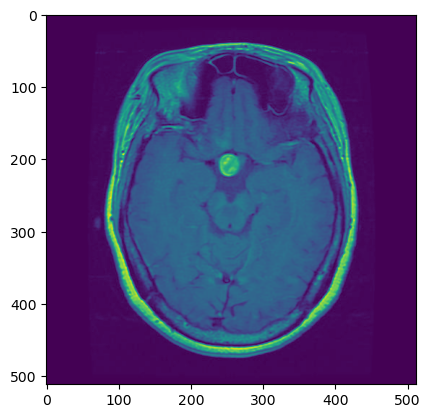

In [22]:
path = "/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0018.jpg"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
image = process_img(path)

In [23]:
image = image.reshape(1, 224, 224, 3)
#prediction
prediction = model.predict(image)
final = np.argmax(prediction)
classi = class_names[final]
print(classi)

1/1 [==============================] - 1s 751ms/step
pituitary


In [24]:
#load explainer
explainer = lime_image.LimeImageExplainer()

In [25]:
#read image and convert into 2D
tem = cv2.imread(path)
tem = cv2.resize(tem, [224,224])
gray_img = cv2.cvtColor(tem, cv2.COLOR_BGR2GRAY)
gray_img.shape

(224, 224)

In [26]:
explanation = explainer.explain_instance(gray_img.astype('double'), model.predict, top_labels=4, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


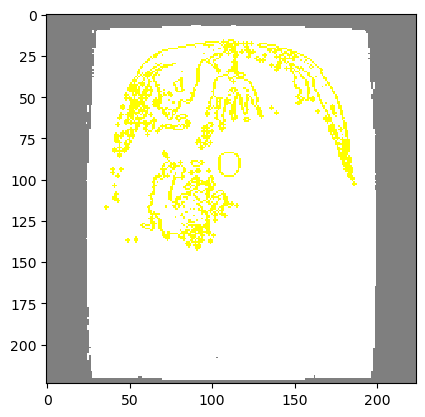

In [27]:
#plot the explantion
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), interpolation='nearest')